In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# All import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Read Data

In [2]:
data = pd.read_csv('~/nu_ds_challenge/ml_assignment_data_train.csv')
print('Shape of the dataset is:', data.shape)
data.head()

Shape of the dataset is: (258325, 11)


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26 18:31:19,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27 22:49:51,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16 17:54:07,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16 00:47:10,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07 17:09:09,165,GB,81349.76,succeeded


# Data Cleaning

- Ensure all columns are the correct dtype
    - 'lauched' and 'deadline' column to datetime dtype


In [3]:
data.dtypes

name              object
category          object
main_category     object
currency          object
deadline          object
goal             float64
launched          object
backers            int64
country           object
usd_goal_real    float64
new_state         object
dtype: object

In [4]:
data_v1 = data.assign(
    deadline = pd.to_datetime(pd.to_datetime(data.deadline).dt.date),
    launched = pd.to_datetime(pd.to_datetime(data.launched).dt.date)
)
data_v1.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,failed
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,failed
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,failed
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,failed
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,succeeded


- Check for missing values
        - 3 missing values in the name column. Delete these rows as they account for less than 0.1% of the dataset

In [5]:
nulls = pd.DataFrame(data_v1.isnull().sum(), columns=['count_nulls']).sort_values(by=['count_nulls'], ascending=False)
nulls[nulls.count_nulls > 0]

,count_nulls
name,3


In [6]:
# removing rows with missing names
data_v2 = data_v1[data_v1.name.isnull() == False]

- Map output variables [failed, succeeded, surged] to [0,1,2]

In [7]:
data_v2['new_state'] = data_v2.new_state.map({'failed':0,'succeeded':1, 'surged':2 })

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
data_v2.new_state.unique()
data_v2.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1


# Initial Feature Engineering

- For date columns
    - time_period = Try deadline - launched
    - Month of year launched
    - Year of launch
- For name column
    - len of title
    - number of words in the title
    - Look at the successful or surged titles, remove stop words and make features of the words (maybe future feature eng)

In [9]:
data_v2['name_length'] = data_v2.name.apply(lambda x: len(x))
data_v2['name_num_words'] = data_v2.name.apply(lambda x: len(x.split()))
data_v2.head()

/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/joashc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7


In [12]:
data_v2 = data_v2.assign(
    launch_month = data_v2.launched.dt.month,
    duration_launched_month = ((data_v2.deadline - data_v2.launched)/np.timedelta64(1, 'M')),
    launch_year = data_v2.launched.dt.year
)
data_v2.head()

,name,category,main_category,currency,deadline,goal,launched,backers,country,usd_goal_real,new_state,name_length,name_num_words,launch_month,launch_duration_month,duration_launched_month,launch_year
0,The Life and Times of a Nutcracker,Fiction,Publishing,USD,2012-12-01,8000.0,2012-10-26,0,US,8000.00,0,34,7,10,1.182776,1.182776,2012
1,Kochi community outreach 2017,Web,Journalism,GBP,2017-04-28,2000.0,2017-02-27,2,GB,2587.82,0,29,4,2,1.971293,1.971293,2017
2,Get Expert Advice for your Fantasy Football Team,Apps,Technology,USD,2016-09-16,1000.0,2016-08-16,3,US,1000.00,0,48,8,8,1.018501,1.018501,2016
3,Realms of the Ancients (ROTA),Tabletop Games,Games,USD,2013-08-02,30000.0,2013-06-16,49,US,30000.00,0,29,5,6,1.544180,1.544180,2013
4,Innr. Change the way you experience lighting,Product Design,Design,GBP,2013-12-07,50000.0,2013-11-07,165,GB,81349.76,1,44,7,11,0.985647,0.985647,2013


# EDA

There are a total of 10 features in the dataset. I want to do some quick introductory analysis on each of them so I have a good understand of the distrubution of the dataset. 

First Up: new_state

In [97]:
data_v2.shape[0]

258322

In [102]:
print('These are the classification variables of the dataset', data_v2.new_state.unique())
class_var = pd.DataFrame(data_v2.new_state.value_counts())
class_var = class_var.assign(percent_class = round(class_var.new_state/258322, 2)*100)
print(class_var)

These are the classification variables of the dataset [0 1 2]
   new_state  percent_class
0     158171           61.0
1      66635           26.0
2      33516           13.0


61%, 26% and 13% of the dataset consist of books that failed, succeeded and surged.


Next: goal and usd_goal_real


I will assume the 'goal' column is also in USD

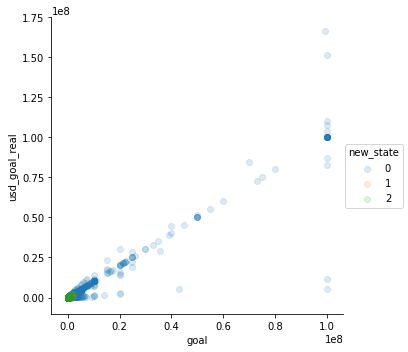

In [48]:
sns.lmplot( x="goal", y="usd_goal_real", 
           data=data_v2, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

Based on the plot, it is evident that the extremely high goals are unlikely to be successful. I hypothesize that this could be due to unrealistic expectations or over hypness of the book. Let's take out some outliers and see the same scatter plot.

Shape of the data removing 99 percentile from the goals columns is: (255738, 11)


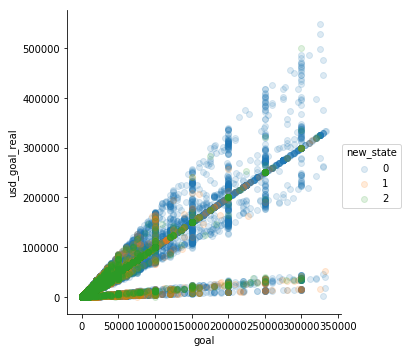

In [108]:
quantile = .99
print('Shape of the data removing 99 percentile from the goals columns is:',
      data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)].shape)

sns.lmplot( x="goal", y="usd_goal_real", 
           data=data_v2[data_v2['goal'] < data_v2.goal.quantile(quantile)], 
           fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

In the plot above, the lower the goal the higher the probability of success.

Next: Currency

There are 14 different currencies in this dataset.
USD    203876
GBP     22949
EUR     11120
CAD      9613
AUD      5083
Name: currency, dtype: int64


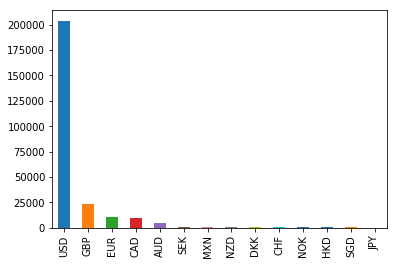

In [35]:
print('There are', data_v2.currency.nunique(), 'different currencies in this dataset.')
print(data_v2.currency.value_counts().head())
data_v2.currency.value_counts().plot(kind="bar")

In the plot above, it is evident that over 75% of the currency in the dataset is USD.


Next: Country

There are 23 different countries in the dataset.
US    203749
GB     22930
CA      9609
AU      5082
DE      2640
Name: country, dtype: int64


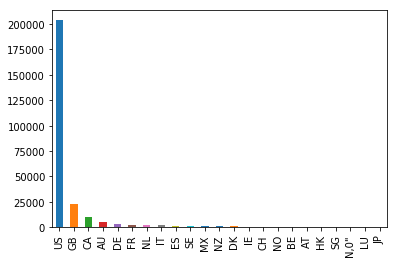

In [36]:
data_v2.country.unique()
print('There are', data_v2.country.nunique(), 'different countries in the dataset.')
print(data_v2.country.value_counts().head())
data_v2.country.value_counts().plot(kind="bar")

The country distribution is similar to the currency distribution

Next: Names of the Books

In [47]:
data_v2.name.nunique()/data_v2.shape[0]
name_counts = pd.DataFrame(data_v2.name.value_counts())
name_counts[name_counts['name'] > 1].shape

print(name_counts[name_counts['name'] > 1].shape[0], 'books in the dataset have duplicate names.',
     'This is', name_counts['name'][name_counts['name'] > 1].sum(), 
      'total rows in the dataset with duplicate book names (', 
      round((1-(data_v2.name.nunique()/data_v2.shape[0])),2)*100,
     '% of the dataset)')

1072 books in the dataset have duplicate names. This is 2432 total rows in the dataset with duplicate book names ( 1.0 % of the dataset)


Next: main_category

There are 15 different main categories.
              main_category
Film & Video          44878
Music                 36541
Publishing            28058
Technology            20676
Games                 20630


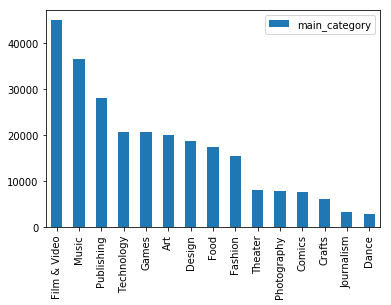

In [64]:
data_v2.main_category.unique()
print('There are', data_v2.main_category.nunique(), 'different main categories.')
main_category_counts = pd.DataFrame(data_v2.main_category.value_counts())
print('Here are the t')
print(main_category_counts.head())
main_category_counts.plot.bar()

For unique book names, I do not think it would add much value to one-hot-encode the names as a feature to the model. There are also very few duplicate names. Thus, other features may have to be extracted from the name which will be done in the feature engineering section of the code!


Next: category

There are a total of 159 categories
Here are the top 5 categories:
                category
Product Design     13723
Documentary        11578
Music              10071
Shorts              9035
Food                8303
Following is a bar plot of the top 20 categories:


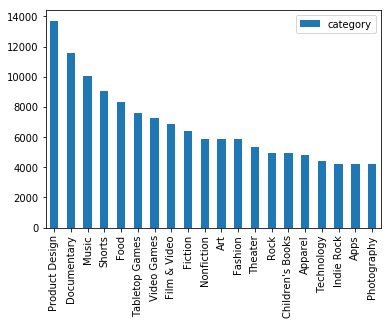

In [58]:
data_v2.category.unique()
print('There are a total of', data_v2.category.nunique(),'categories')
print('Here are the top 5 categories:')
category_counts = pd.DataFrame(data_v2.category.value_counts())
print(category_counts.head())
print('Following is a bar plot of the top 20 categories:')
category_counts.head(20).plot.bar()

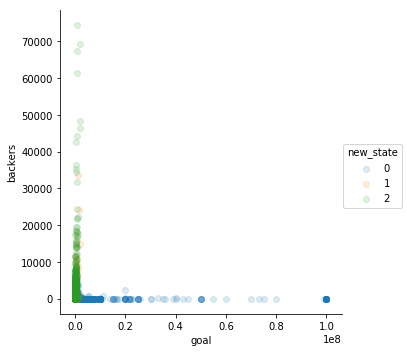

In [71]:
sns.lmplot( x="goal", y="backers", 
           data=data_v2, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

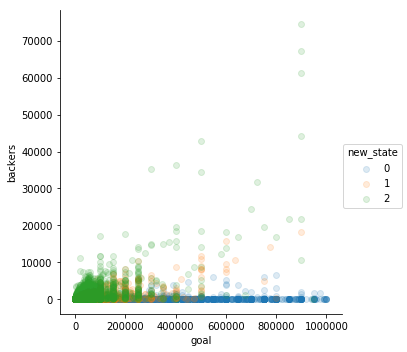

In [79]:
test = data_v2[data_v2['goal'] < 1000000]
sns.lmplot( x="goal", y="backers", 
           data=test, fit_reg=False, hue='new_state', legend=True, scatter_kws={'alpha':0.15})

# Feature Eng
- For date columns
    - time_period = Try deadline - launched
    - Time of year lauched (Q1, Q2, Q3, Q4)
    - Month of year launched
    - 
- len of title
- number of words in the title
- Look at the successful or surged titles, remove stop words and make features of the words.